In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
#processed data loading
X_train = pd.read_parquet("data/processed/X_train.parquet")
X_val   = pd.read_parquet("data/processed/X_val.parquet")

print("X_train:", X_train.shape, "X_val:", X_val.shape)

X_train: (25947591, 8) X_val: (6486898, 8)


In [3]:
TARGET = "mean_days_between_orders"  # هدف الريغريشن

X_train = X_train.copy()
X_val   = X_val.copy()

y_train = X_train[TARGET].copy()
y_val   = X_val[TARGET].copy()

X_train = X_train.drop(columns=[TARGET])
X_val   = X_val.drop(columns=[TARGET])

print("Target:", TARGET)
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train:", y_train.shape, "y_val:", y_val.shape)

Target: mean_days_between_orders
X_train: (25947591, 7) X_val: (6486898, 7)
y_train: (25947591,) y_val: (6486898,)


In [4]:
y_train = pd.to_numeric(y_train, errors="coerce")
y_val   = pd.to_numeric(y_val, errors="coerce")

train_mask = y_train.notna() & np.isfinite(y_train)
val_mask   = y_val.notna() & np.isfinite(y_val)

X_train, y_train = X_train.loc[train_mask], y_train.loc[train_mask]
X_val, y_val     = X_val.loc[val_mask], y_val.loc[val_mask]

print("After cleaning:", X_train.shape, X_val.shape)
print("y_train describe:\n", y_train.describe())
print("Any NaN in X_train?", X_train.isna().any().any())
print("Any NaN in X_val?", X_val.isna().any().any())

After cleaning: (25947591, 7) (6486898, 7)
y_train describe:
 count    2.594759e+07
mean     1.137451e+01
std      6.055780e+00
min      0.000000e+00
25%      6.852941e+00
50%      9.883459e+00
75%      1.486513e+01
max      3.000000e+01
Name: mean_days_between_orders, dtype: float64
Any NaN in X_train? True
Any NaN in X_val? True


In [5]:
#taking samples from slower models
def subsample_reg(X, y, n, random_state=42):
    n = min(n, len(X))
    X_s, _, y_s, _ = train_test_split(
        X, y, train_size=n, random_state=random_state
    )
    return X_s, y_s

In [6]:
# (MAE/MSE/RMSE/R2/AdjR2)

def adjusted_r2(r2, n, p):
    # Adjusted R^2 useful when p is large relative to n
    if n <= p + 1:
        return np.nan
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def eval_regression(model, X, y, name, do_diagnostics=False, diag_sample_n=200_000):
    y_pred = model.predict(X)

    mae  = mean_absolute_error(y, y_pred)
    mse  = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y, y_pred)

    n = len(y)
    p = X.shape[1]
    adj = adjusted_r2(r2, n, p)

    out = {
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adj_R2": adj,
        "N_eval": n,
        "p_features": p
    }

    if do_diagnostics:
        if n > diag_sample_n:
            rng = np.random.RandomState(42)
            idx = rng.choice(n, size=diag_sample_n, replace=False)
            y_s = np.asarray(y)[idx]
            y_pred_s = np.asarray(y_pred)[idx]
        else:
            y_s = np.asarray(y)
            y_pred_s = np.asarray(y_pred)

        resid = y_s - y_pred_s

        # Residuals vs Fitted plot
        plt.figure()
        plt.scatter(y_pred_s, resid, s=4, alpha=0.3)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Fitted values (y_pred)")
        plt.ylabel("Residuals (y - y_pred)")
        plt.title(f"{name} — Residuals vs Fitted")
        plt.show()

        # Q-Q plot for residual normality
        plt.figure()
        sm.qqplot(resid, line="45", fit=True)
        plt.title(f"{name} — Q-Q Plot (Residuals)")
        plt.show()

        # Breusch–Pagan test for heteroscedasticity
        exog = sm.add_constant(y_pred_s)
        bp = het_breuschpagan(resid, exog)
        out["BP_LM_stat"] = bp[0]
        out["BP_LM_pvalue"] = bp[1]
        out["BP_F_stat"] = bp[2]
        out["BP_F_pvalue"] = bp[3]

    return out


In [7]:
# Linear models (need scaling)
ols = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

lasso = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.001, random_state=42, max_iter=5000))
])

elastic = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=5000))
])

# KNN (slow -> we will subsample)
knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KNeighborsRegressor(n_neighbors=25, weights="distance"))
])

# SVR (very slow -> small subsample)
svr_linear = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="linear", C=1.0, epsilon=0.1))
])

svr_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=5.0, gamma="scale", epsilon=0.1))
])

# Tree models (no scaling)
dt = DecisionTreeRegressor(max_depth=14, min_samples_leaf=100, random_state=42)

rf = RandomForestRegressor(
    n_estimators=80,
    max_depth=14,
    min_samples_leaf=100,
    max_features="sqrt",
    bootstrap=False,
    n_jobs=1,
    random_state=42
)

In [8]:
#preparing gradient boosting for (XGBoost or LightGBM)
HAS_XGB = False
HAS_LGBM = False

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    pass

try:
    from lightgbm import LGBMRegressor
    HAS_LGBM = True
except ImportError:
    pass

print("XGB available:", HAS_XGB)
print("LGBM available:", HAS_LGBM)

if HAS_XGB:
    gb = XGBRegressor(
        n_estimators=1200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=4,
        tree_method="hist"
    )
elif HAS_LGBM:
    gb = LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=4
    )
else:
    raise ImportError("Install xgboost or lightgbm for the required boosting regressor.")

XGB available: True
LGBM available: True


In [9]:
#training models with different sampling

# Linear family (medium sample)
X_lin_tr, y_lin_tr = subsample_reg(X_train, y_train, n=1_000_000)
ols.fit(X_lin_tr, y_lin_tr)
ridge.fit(X_lin_tr, y_lin_tr)
lasso.fit(X_lin_tr, y_lin_tr)
elastic.fit(X_lin_tr, y_lin_tr)

# Decision tree (larger sample)
X_tree_tr, y_tree_tr = subsample_reg(X_train, y_train, n=2_000_000)
dt.fit(X_tree_tr, y_tree_tr)

# Random forest (small sample)
X_rf_tr, y_rf_tr = subsample_reg(X_train, y_train, n=200_000)
rf.fit(X_rf_tr, y_rf_tr)

# KNN (small sample)
X_knn_tr, y_knn_tr = subsample_reg(X_train, y_train, n=150_000)
knn.fit(X_knn_tr, y_knn_tr)

# SVR (very small sample)
X_svr_tr, y_svr_tr = subsample_reg(X_train, y_train, n=50_000)
svr_linear.fit(X_svr_tr, y_svr_tr)
svr_rbf.fit(X_svr_tr, y_svr_tr)

# Boosting (medium sample)
X_gb_tr, y_gb_tr = subsample_reg(X_train, y_train, n=2_000_000)
gb.fit(X_gb_tr, y_gb_tr)

print("Training done ✅")


Training done ✅


In [12]:
# This cell evaluates all regression models using the required metrics.
# Slow models are evaluated on smaller validation subsamples to control runtime and memory usage.

models = {
    "OLS": ols,
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elastic,
    "KNN": knn,
    "SVR (linear)": svr_linear,
    "SVR (RBF)": svr_rbf,
    "Decision Tree": dt,
    "Random Forest": rf,
    "Boosting (XGB/LGBM)": gb
}

# Define which models are computationally slow
slow_knn = {"KNN"}                           # Distance-based prediction
slow_svr = {"SVR (linear)", "SVR (RBF)"}     # Kernel-based models (very slow on large N)
slow_rf  = {"Random Forest"}                 # Many trees → higher memory usage

# Create validation subsamples for slow models
X_val_knn, y_val_knn = subsample_reg(X_val, y_val, n=100_000)   # Moderate size for KNN
X_val_svr, y_val_svr = subsample_reg(X_val, y_val, n=20_000)    # Small size for SVR
X_val_rf,  y_val_rf  = subsample_reg(X_val, y_val, n=300_000)   # Larger subsample for RF

rows = []

for name, model in models.items():

    # Select evaluation set based on model speed
    if name in slow_knn:
        X_e, y_e = X_val_knn, y_val_knn
        note = f"val_subsample(n={len(y_e)})"

    elif name in slow_svr:
        X_e, y_e = X_val_svr, y_val_svr
        note = f"val_subsample(n={len(y_e)})"

    elif name in slow_rf:
        X_e, y_e = X_val_rf, y_val_rf
        note = f"val_subsample(n={len(y_e)})"

    else:
        X_e, y_e = X_val, y_val
        note = f"val_full(n={len(y_e)})"

    # Evaluate regression metrics (MAE, MSE, RMSE, R², etc.)
    r = eval_regression(model, X_e, y_e, name, do_diagnostics=False)
    r["Eval_Set"] = note
    rows.append(r)

    print("Done:", name, note)

# Final results table sorted by RMSE (low
results_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
results_df

Done: OLS val_full(n=6486898)
Done: Ridge val_full(n=6486898)
Done: Lasso val_full(n=6486898)
Done: ElasticNet val_full(n=6486898)
Done: KNN val_subsample(n=100000)
Done: SVR (linear) val_subsample(n=20000)
Done: SVR (RBF) val_subsample(n=20000)
Done: Decision Tree val_full(n=6486898)
Done: Random Forest val_subsample(n=300000)
Done: Boosting (XGB/LGBM) val_full(n=6486898)


,Model,MAE,MSE,RMSE,R2,Adj_R2,N_eval,p_features,Eval_Set
0,Boosting (XGB/LGBM),4.273711,29.776512,5.456786,0.188429,0.188428,6486898,7,val_full(n=6486898)
1,Random Forest,4.297738,30.025607,5.479563,0.178793,0.178774,300000,7,val_subsample(n=300000)
2,Decision Tree,4.301834,30.155460,5.491399,0.178101,0.178100,6486898,7,val_full(n=6486898)
3,Ridge,4.392763,30.926901,5.561196,0.157075,0.157074,6486898,7,val_full(n=6486898)
4,OLS,4.392763,30.926901,5.561196,0.157075,0.157074,6486898,7,val_full(n=6486898)
5,ElasticNet,4.392708,30.926905,5.561196,0.157075,0.157074,6486898,7,val_full(n=6486898)
6,Lasso,4.392746,30.926913,5.561197,0.157075,0.157074,6486898,7,val_full(n=6486898)
7,SVR (RBF),4.261652,31.433692,5.606576,0.146137,0.145838,20000,7,val_subsample(n=20000)
8,SVR (linear),4.302763,32.117918,5.667267,0.127550,0.127245,20000,7,val_subsample(n=20000)
9,KNN,4.671893,36.947671,6.078460,-0.006482,-0.006553,100000,7,val_subsample(n=100000)


In [14]:
'''comparing between the training and testing just to make sure the model isnt overfitting'''
eval_regression(
    gb,
    X_train.sample(300_000, random_state=42),
    y_train.sample(300_000, random_state=42),
    "GB train sample",
    do_diagnostics=False
)

{'Model': 'GB train sample',
 'MAE': 4.275673623982011,
 'MSE': 29.842891212492752,
 'RMSE': np.float64(5.462864744114826),
 'R2': 0.18899200287270745,
 'Adj_R2': 0.18897307884813375,
 'N_eval': 300000,
 'p_features': 7}

Top 2 models: ['Boosting (XGB/LGBM)', 'Random Forest']


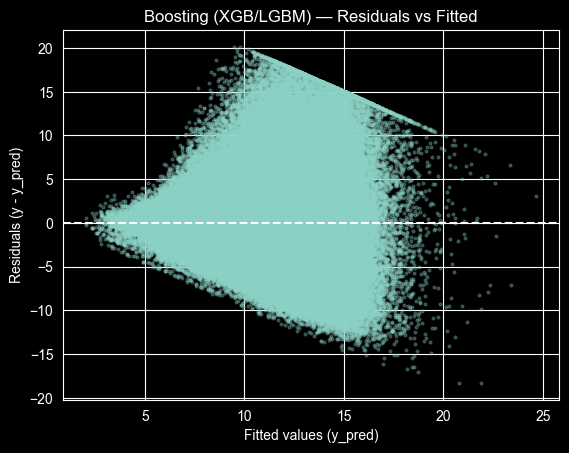

<Figure size 640x480 with 0 Axes>

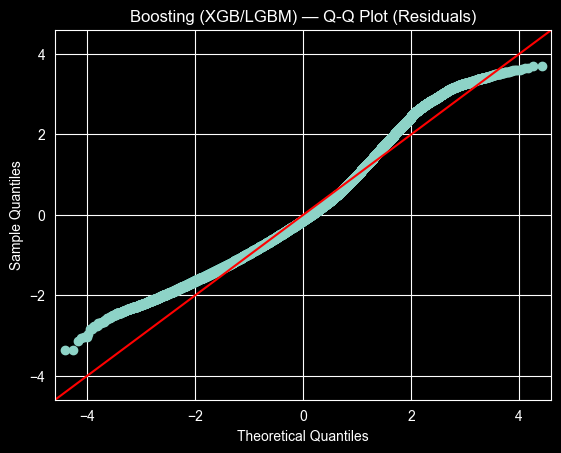

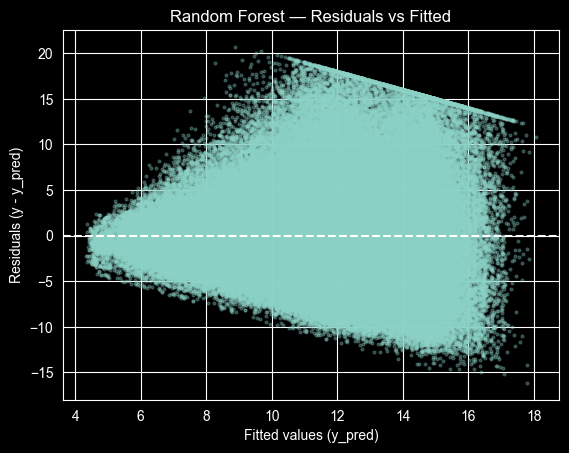

<Figure size 640x480 with 0 Axes>

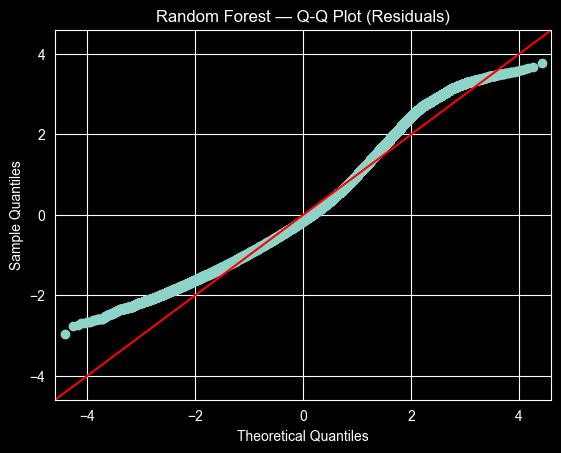

,Model,RMSE,R2,Adj_R2,BP_LM_pvalue,BP_F_pvalue
0,Boosting (XGB/LGBM),5.450162,0.187582,0.187563,0.0,0.0
1,Random Forest,5.479563,0.178793,0.178774,0.0,0.0


In [13]:
#(Residual plot + Q-Q + Breusch-Pagan) for the best 2 models only (runtime issues)

top2 = results_df["Model"].head(2).tolist()
print("Top 2 models:", top2)

# عينة تشخيص لتقليل الرسم
X_diag, y_diag = subsample_reg(X_val, y_val, n=300_000)

diag_rows = []
for name in top2:
    row = eval_regression(models[name], X_diag, y_diag, name, do_diagnostics=True, diag_sample_n=200_000)
    diag_rows.append(row)

pd.DataFrame(diag_rows)[["Model","RMSE","R2","Adj_R2","BP_LM_pvalue","BP_F_pvalue"]]
